In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [18]:
sdir=r'/kaggle/input/poultry/train'
slist=os.listdir(sdir)
classes=[]
filepaths=[]
labels=[]
for d in slist:
    dpath=os.path.join(sdir, d)
    if os.path.isdir(dpath):
        classes.append(d)
class_count=len(classes)
for klass in classes:
    classpath=os.path.join(sdir,klass)
    filelist=os.listdir(classpath)
    for f in filelist:
        fpath=os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)
print ('number of files: ', len(filepaths), '   number of labels: ', len(labels))
file_series=pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)
print (df.head())

number of files:  3682    number of labels:  3682
                                           filepaths labels
0  /kaggle/input/poultry/train/salmo/salmo-492_jp...  salmo
1  /kaggle/input/poultry/train/salmo/salmo-422_jp...  salmo
2  /kaggle/input/poultry/train/salmo/salmo-53_jpg...  salmo
3  /kaggle/input/poultry/train/salmo/salmo-260_jp...  salmo
4  /kaggle/input/poultry/train/salmo/salmo-1174_j...  salmo


In [19]:
balance=df['labels'].value_counts()
print (balance)

labels
ncd        949
salmo      938
healthy    906
cocci      889
Name: count, dtype: int64


In [20]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=125)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=125)
print ('train size: ', len(train_df), '  test size: ', len(test_df), '   valid size: ', len(valid_df))
length=len(test_df)

train size:  2945   test size:  368    valid size:  369


In [21]:
batch_size=16
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=True, seed=123)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=batch_size, shuffle=False)
# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                   batch_size=test_batch_size, shuffle=False)
test_labels=test_gen.labels

Found 2945 validated image filenames belonging to 4 classes.
Found 369 validated image filenames belonging to 4 classes.
Found 368 validated image filenames belonging to 4 classes.


In [22]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 18)) # Adjusted figure size for better display
    length=len(labels)
    if length<30:   #show maximum of 30 images
        r=length
    else:
        r=30
    for i in range(r):
        plt.subplot(6, 5, i + 1) # Changed grid to 6x5 to accommodate 30 subplots
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

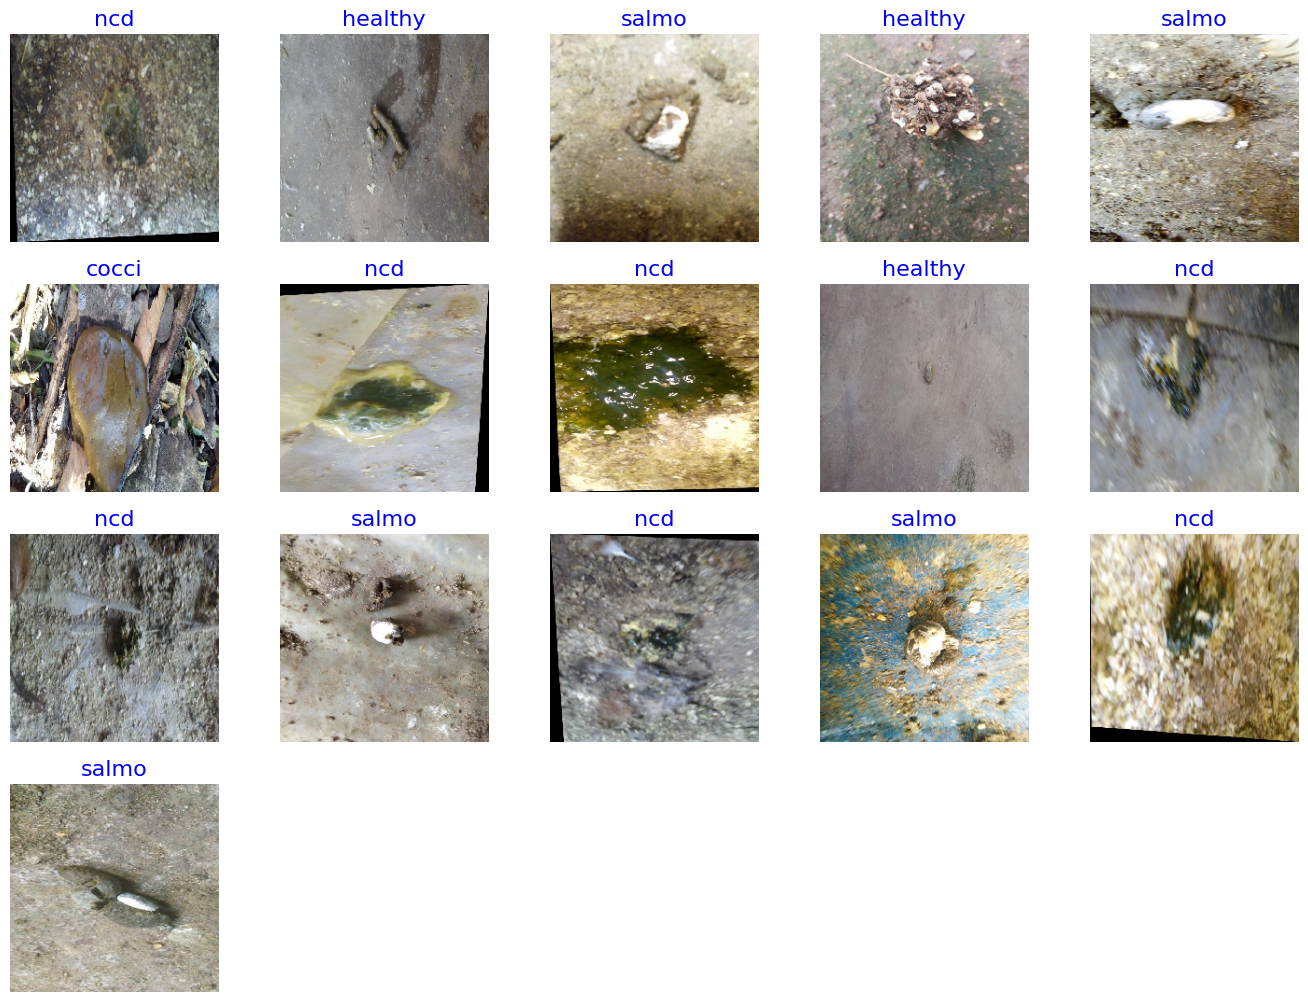

In [23]:
show_training_samples(train_gen)

In [24]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, Input

# Load DenseNet121 pre-trained model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  # Add global average pooling
x = layers.Dense(256, activation='relu')(x)  # Optional dense layer for additional learning
outputs = layers.Dense(class_count, activation='softmax')(x)  # Output layer with class_count classes

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,070,148 (49.86 MB)

 Trainable params: 427,268 (1.63 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [25]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 73s 229ms/step - accuracy: 0.7459 - loss: 0.7186 - val_accuracy: 0.9051 - val_loss: 0.2776
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9405 - loss: 0.2125 - val_accuracy: 0.9322 - val_loss: 0.2050
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9656 - loss: 0.1286 - val_accuracy: 0.9485 - val_loss: 0.1577
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9647 - loss: 0.1103 - val_accuracy: 0.9621 - val_loss: 0.1363
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9790 - loss: 0.0856 - val_accuracy: 0.9539 - val_loss: 0.1224
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9842 - loss: 0.0640 - val_accuracy: 0.9566 - val_loss: 0.1153
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9858 - loss: 0.0581 - val_accuracy: 0.9593 - val_loss: 0.1193
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9895 - loss: 0.0514 - val_accura

In [26]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

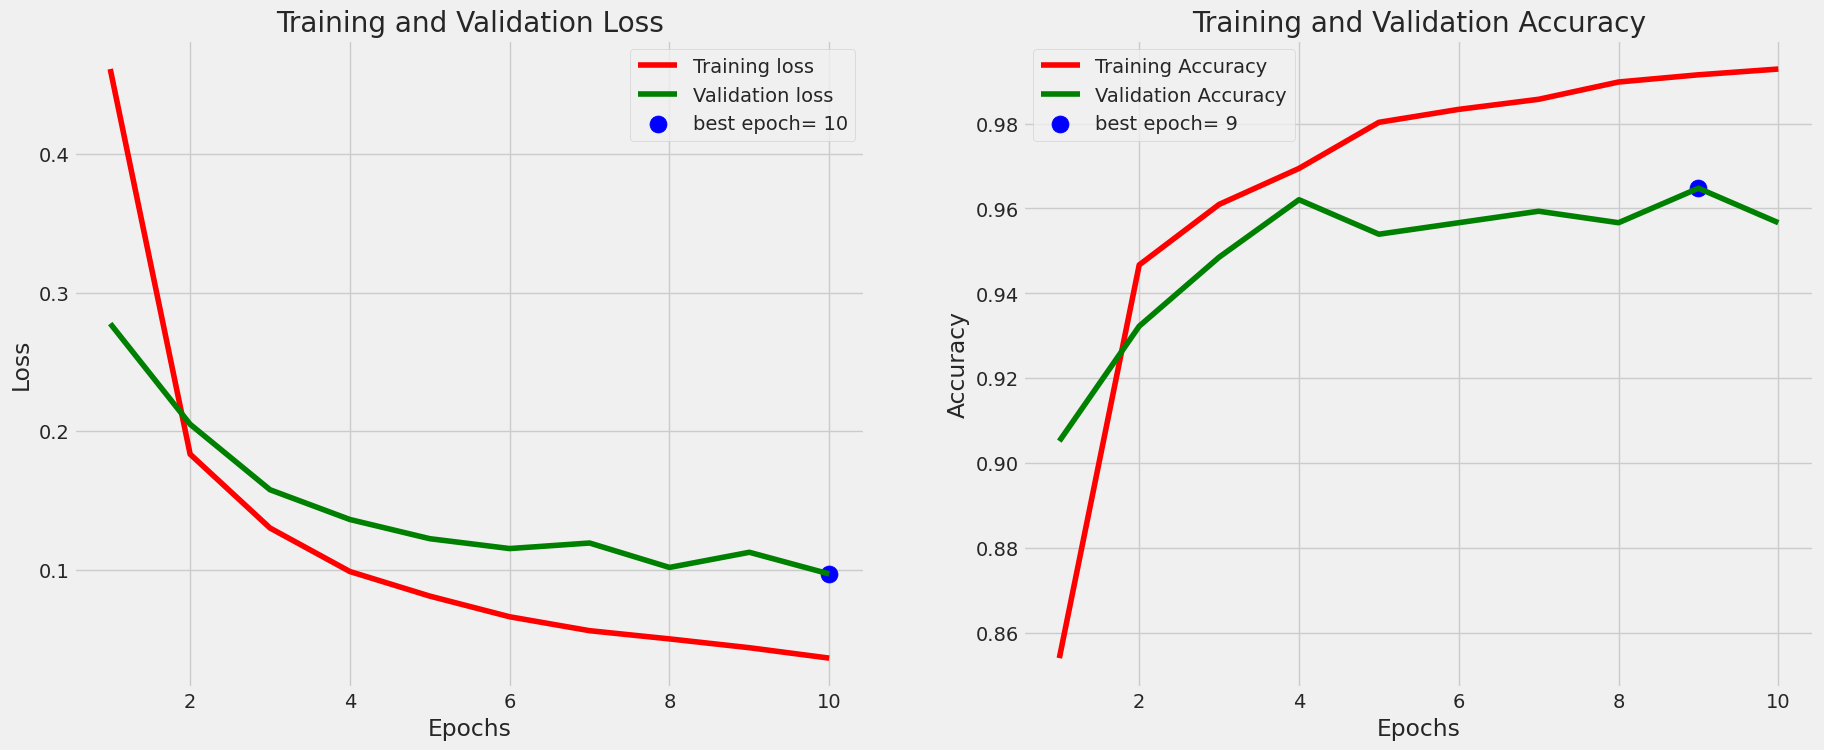

In [27]:
tr_plot(history, 0)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step
Confusion Matrix
[[ 95   0   0   0]
 [  0 101   1   1]
 [  0   1  77   0]
 [  1   3   0  88]]
Classification Report
              precision    recall  f1-score   support

       cocci       0.99      1.00      0.99        95
     healthy       0.96      0.98      0.97       103
         ncd       0.99      0.99      0.99        78
       salmo       0.99      0.96      0.97        92

    accuracy                           0.98       368
   macro avg       0.98      0.98      0.98       368
weighted avg       0.98      0.98      0.98       368



RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

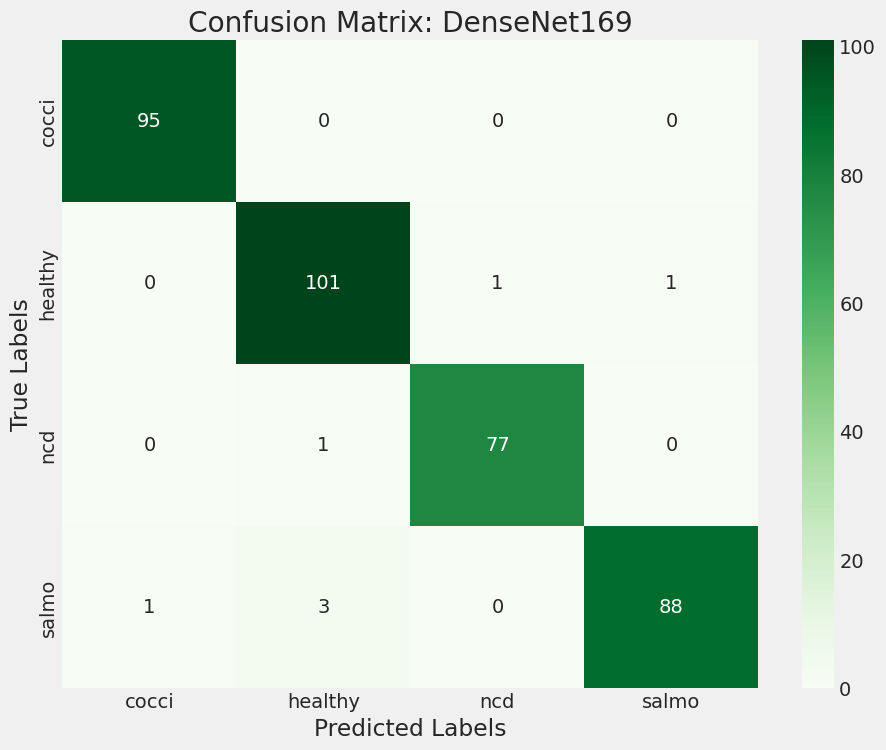

In [28]:
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
class_names = list(test_gen.class_indices.keys())
print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)
print(cm)

print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: DenseNet169')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar(label='Count')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


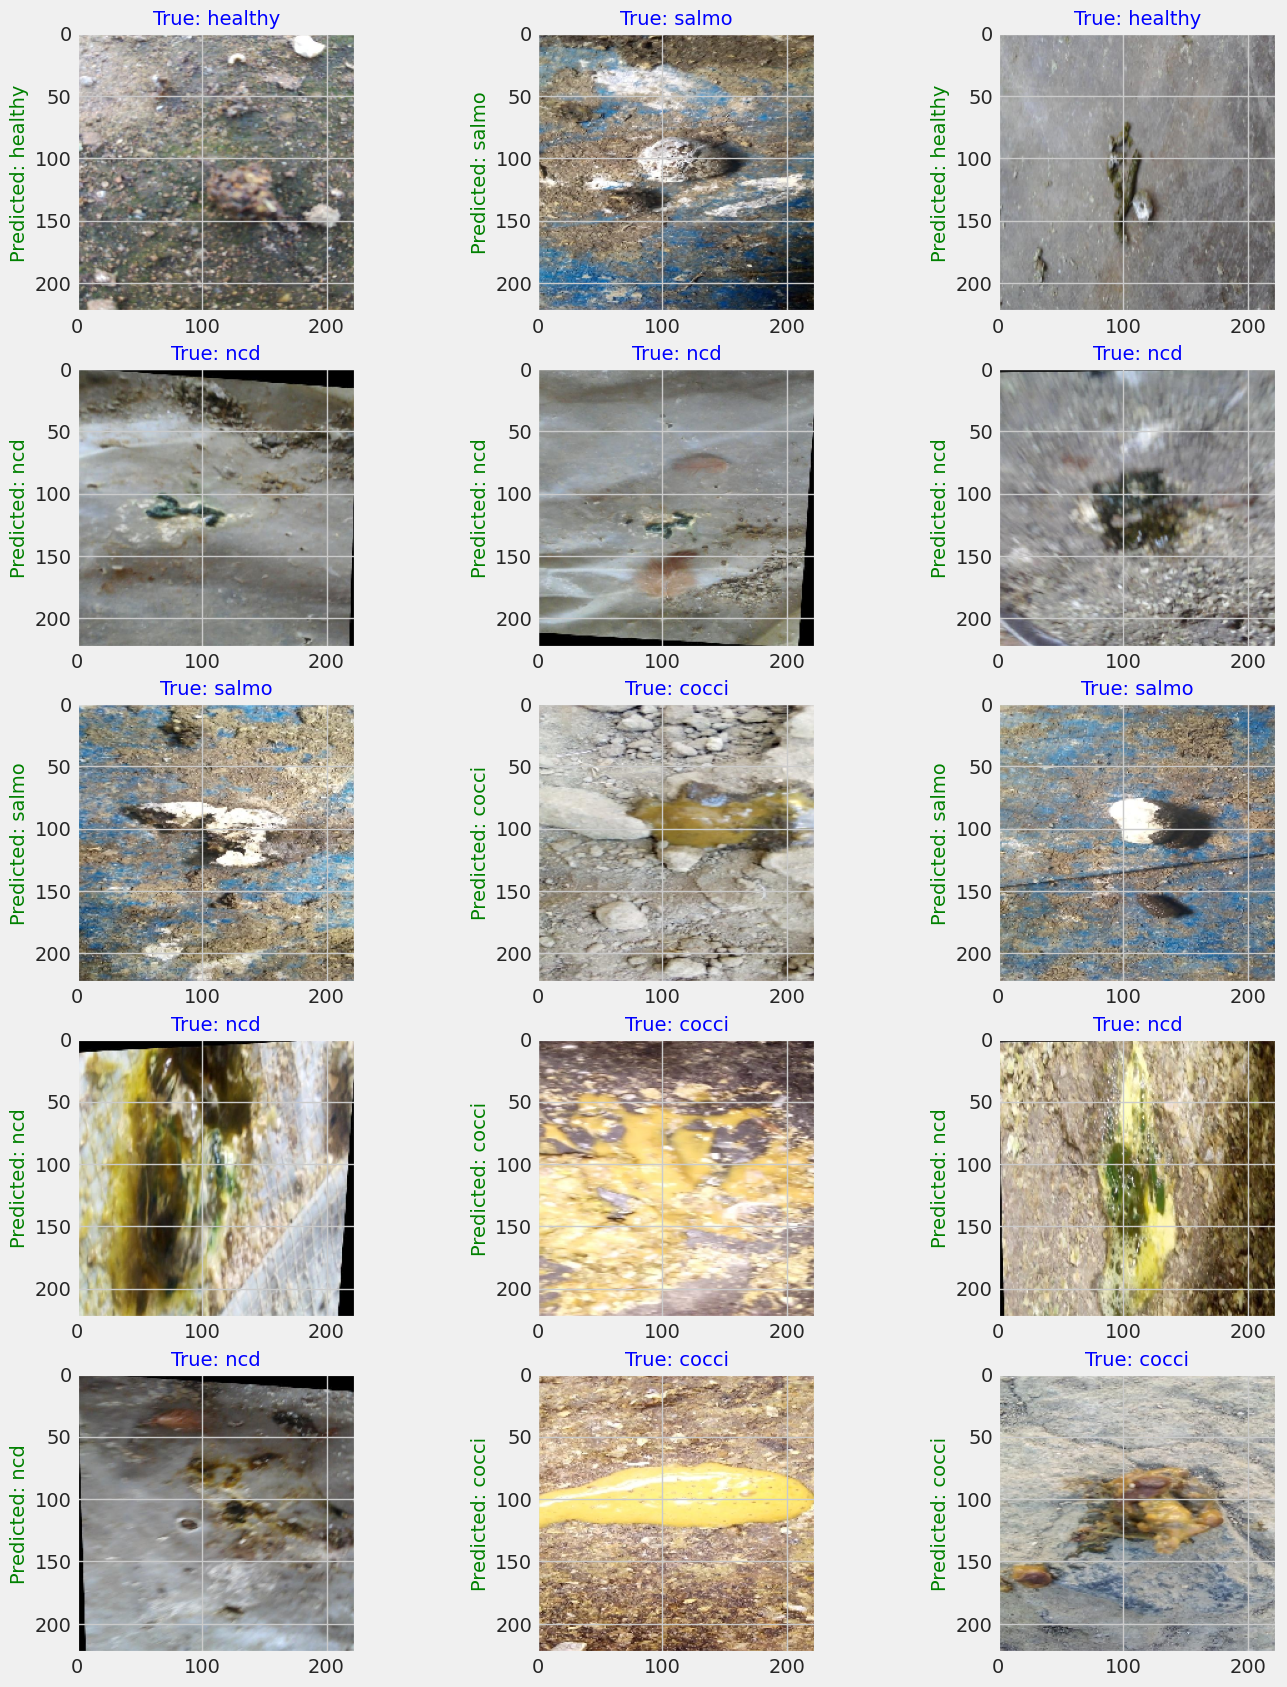

In [29]:
def print_images(gen):
    class_dict = gen.class_indices
    new_dict = {}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items():
        new_dict[value] = key
    images, labels = next(gen)
    plt.figure(figsize=(15, 20))
    length = len(labels)
    if length < 15:
        r = length
    else:
        r = 15
    for i in range(r):
        plt.subplot(5, 3, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = new_dict[index]
        pred = model.predict(np.expand_dims(images[i], axis=0))
        pred_index = np.argmax(pred)
        pred_class_name = new_dict[pred_index]
        plt.title(f"True: {class_name}", color='blue', fontsize=14) # Set true class title color to blue
        plt.ylabel(f"Predicted: {pred_class_name}", color='green', fontsize=14) # Set predicted class title color to green and moved it to xlabel for better visibility
        plt.axis('on')
    plt.show()

print_images(train_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

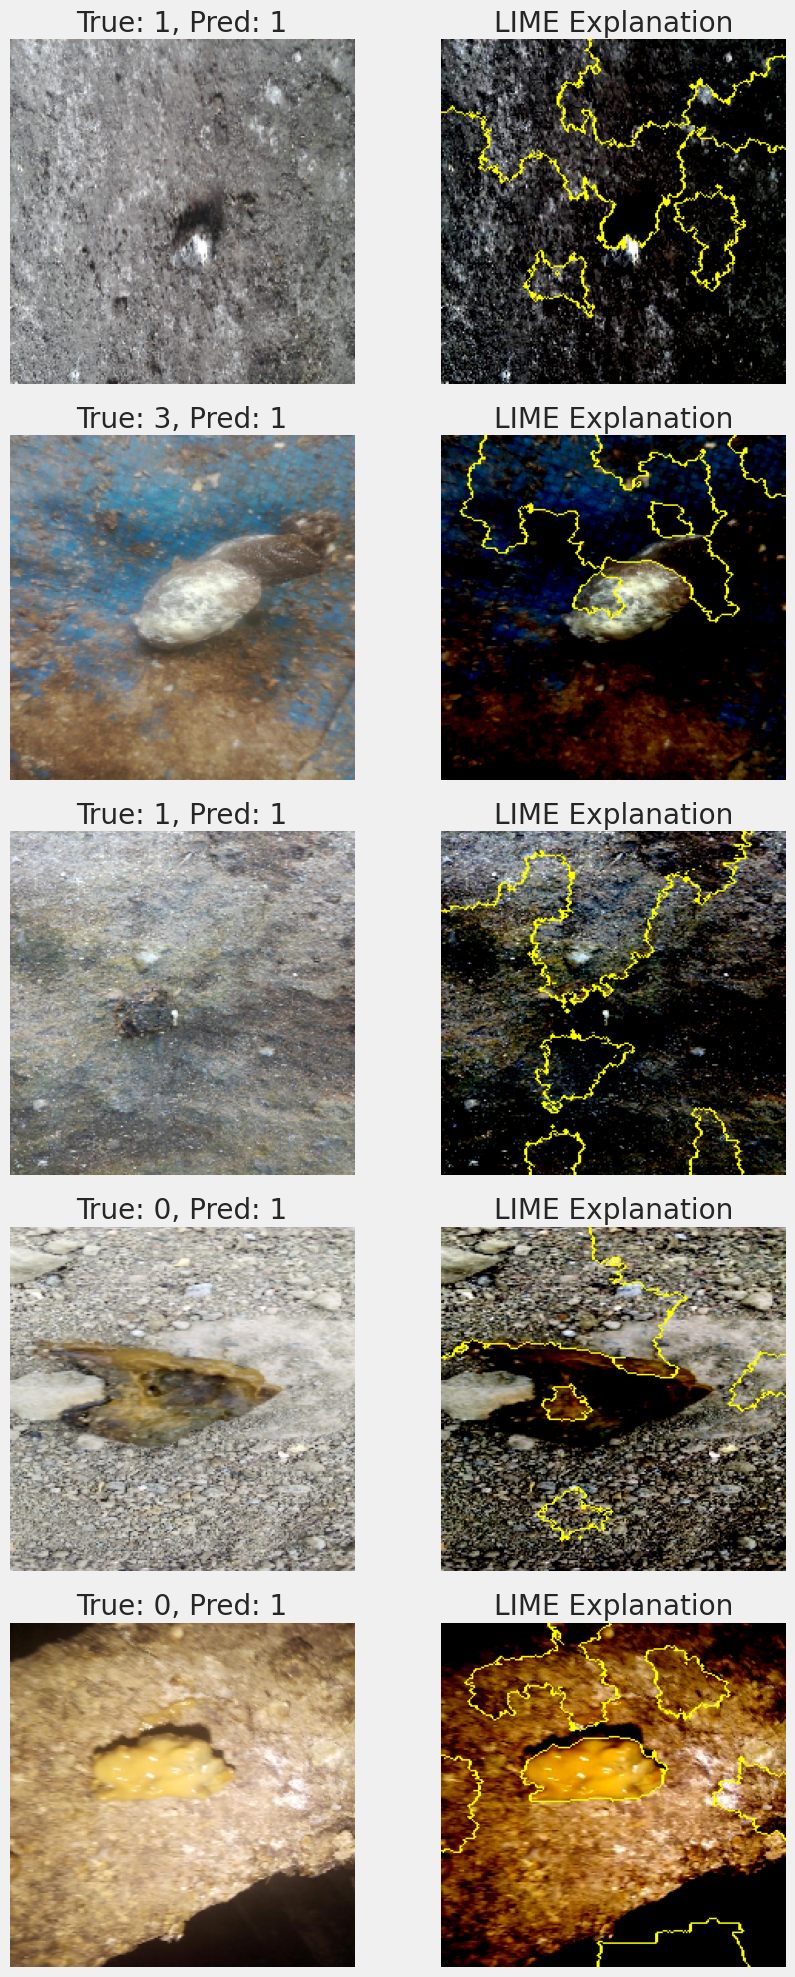

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

# Define the prediction function for LIME (which matches your model setup)
def predict_fn(images):
    images = np.array(images)  # Convert list of images to a numpy array
    images = (images / 127.5) - 1  # Rescale the images to [-1, 1]
    return model.predict(images)  # Return predictions from the model

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Number of images to process
num_images_to_process = 5

# Get 5 random indices from the dataset
random_indices = random.sample(range(len(test_gen)), num_images_to_process)

# Set up the subplot grid (5 rows, 2 columns)
fig, axes = plt.subplots(num_images_to_process, 2, figsize=(10, 4 * num_images_to_process))

# Loop through random indices and process images
for i, idx in enumerate(random_indices):
    test_image_batch, true_label_batch = test_gen[idx]  # Fetch the batch
    test_image = test_image_batch[0]  # Use the first image in the batch
    true_label = np.argmax(true_label_batch[0])  # Convert one-hot to index
    
    # Get model predictions for this image
    predicted_probs = model.predict(np.expand_dims(test_image, axis=0))[0]  # Model prediction for the image
    predicted_label = np.argmax(predicted_probs)  # Predicted class label
    
    # Generate LIME explanation for the current image
    explanation = explainer.explain_instance(
        test_image.astype('double'),  # Ensure the image is in double precision
        predict_fn,                   # The function that makes predictions
        top_labels=1,                 # Only get explanation for the top class
        hide_color=0,                 # Color for hidden segments
        num_samples=500               # Number of perturbed samples
    )
    
    # Get the top label(s) from the explanation
    top_labels = explanation.top_labels  # Get the top labels from LIME's explanation
    
    # Ensure the predicted label is in top_labels, or use the first available one
    if predicted_label not in top_labels:
        predicted_label = top_labels[0]

    # Get the image and mask for the predicted label
    temp, mask = explanation.get_image_and_mask(
        label=predicted_label,        # Explanation for the predicted class
        positive_only=True,           # Focus on positive contributions
        num_features=10,              # Number of superpixels
        hide_rest=False               # Show all regions with boundaries
    )
    
    # Display the original image in the first column
    axes[i, 0].imshow((test_image + 1) / 2)  # Rescale to [0, 1] for display
    axes[i, 0].set_title(f"True: {true_label}, Pred: {predicted_label}")
    axes[i, 0].axis('off')
    
    # Display the LIME explanation in the second column
    axes[i, 1].imshow(mark_boundaries(temp.astype('uint8') if temp.max() > 1 else temp, mask))
    axes[i, 1].set_title("LIME Explanation")
    axes[i, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('/kaggle/working/lime_explanation.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()